In [28]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install arabic-reshaper python-bidi rasterio --quiet

In [29]:

# خواندن فایل CSV (از مسیر اصلی چون توی ریشه هست)
df = pd.read_csv("final_dataset_with_predictions.csv")


In [30]:

# تعداد اولیه سطرها
original_count = len(df)


# حذف ستون Flood به‌خاطر لو رفتن هدف (leakage)
df.drop(columns=["Flood"], inplace=True)
print("ستون Flood حذف شد به‌خاطر لو رفتن هدف ")

# مرحله 1: حذف سطرهایی که فاصله از رودخانه کمتر یا مساوی صفر است
df_step1 = df[df["DistanceToRiver"] > 0]
removed_step1 = original_count - len(df_step1)

# مرحله 2: حذف landcoverr == 10
df_step2 = df_step1[df_step1["landcoverr"] != 10]
removed_step2 = len(df_step1) - len(df_step2)

# مرحله 3: حذف سطرهای دارای مقادیر خالی (NaN)
df_clean = df_step2.dropna()
removed_step3 = len(df_step2) - len(df_clean)




ستون Flood حذف شد به‌خاطر لو رفتن هدف 


In [31]:
# دیکشنری تغییر نام
rename_dict = {
    "Elevation": "Elevation",
    "Rainfall": "Rainfall",
    "Slopee": "Slope",
    "Aspectt": "Aspect",
    "SlopeLengthFactor": "SLF",
    "SOIL_CODE": "Soil_type",
    "GEO_UNIT_ENC": "Lithology",  # ← اصلاح شد
    "landcoverr": "Land_Cover",
    "NDVI2": "NDVI",
    "TopographicPositionIndex": "TPI",
    "TopographicWetnessIndex": "TWI",
    "DistanceToRiver": "Distance_to_River",
    "DrainageDensity": "Drainage_Density",
    "SedimentTransportIndex": "STI",
    "FlowDirection": "Flow_Direction",
    "FlowAccumulation": "Flow_Accumulation",
    "StreamPowerIndex": "SPI",
    "ProfileCurvature": "Profile_Curvature",
    "PlanCurvature": "Plan_Curvature"
}

# اعمال تغییر نام روی df و df_clean (اگه df_clean قبلاً ساخته شده)
df.rename(columns=rename_dict, inplace=True)
if 'df_clean' in globals():
    df_clean.rename(columns=rename_dict, inplace=True)

# بررسی نتیجه
print("📝 نام ستون‌ها پس از تغییر:")
print(df.columns.tolist())


📝 نام ستون‌ها پس از تغییر:
['Aspect', 'NDVI', 'SLF', 'Land_Cover', 'Distance_to_River', 'Plan_Curvature', 'Slope', 'Drainage_Density', 'Profile_Curvature', 'SPI', 'Flow_Accumulation', 'Rainfall', 'TPI', 'Flow_Direction', 'STI', 'TWI', 'x', 'y', 'Soil_type', 'Elevation', 'Lithology', 'Prediction']


In [32]:
# تعداد مقادیر یکتای Prediction
print("Unique values in 'Prediction':", df_clean['Prediction'].unique())

# نمایش آماری
print("\nValue counts:")
print(df_clean['Prediction'].value_counts())

Unique values in 'Prediction': [1 0]

Value counts:
Prediction
0    790
1    785
Name: count, dtype: int64


📊 فیچرهای مؤثر (Importance >= 0.01):
              Feature  Importance
17          Elevation    0.235004
6               Slope    0.112798
16          Soil_type    0.077171
4   Distance_to_River    0.075521
18          Lithology    0.072228
3          Land_Cover    0.065167
1                NDVI    0.056707
7    Drainage_Density    0.055280
11           Rainfall    0.051959
15                TWI    0.043884
2                 SLF    0.042092
12                TPI    0.023947
5      Plan_Curvature    0.019866
8   Profile_Curvature    0.017962
0              Aspect    0.015979
9                 SPI    0.010408


/tmp/ipython-input-33-700982927.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=important_feats, palette="Blues_r")


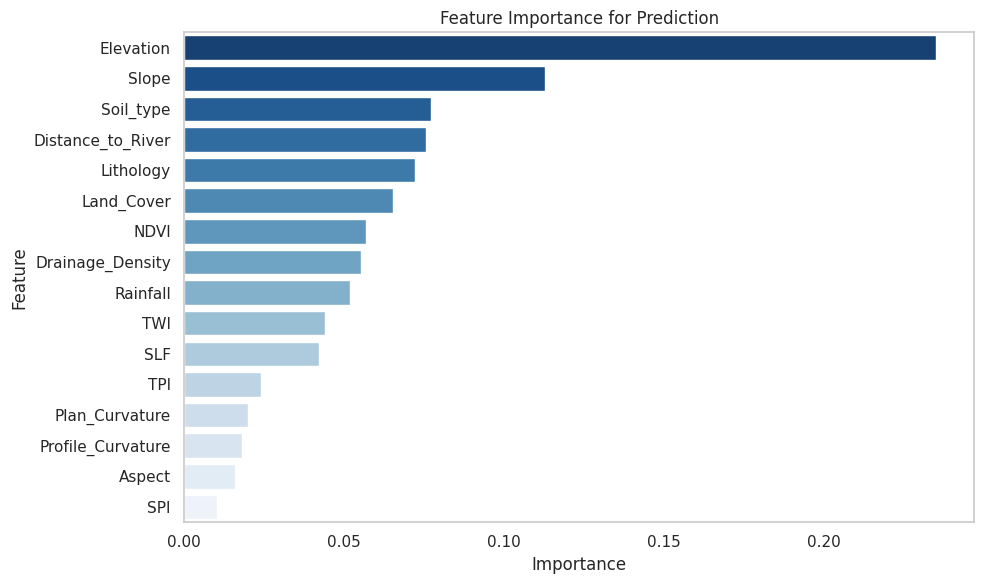

In [33]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# آماده‌سازی داده‌ها (ستون‌هایی که حذف می‌شن نیازی به rename ندارن)
X = df_clean.drop(columns=["x", "y", "Prediction", "Hazard_Level", "Hazard_Level_Label", "Hazard_Score"], errors='ignore')
y = df_clean["Prediction"]

# آموزش مدل اولیه برای تحلیل اهمیت ویژگی‌ها
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# استخراج اهمیت ویژگی‌ها
importances = model.feature_importances_
features = X.columns

# ساخت دیتافریم مرتب‌شده
feat_imp = pd.DataFrame({"Feature": features, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

# فقط ویژگی‌هایی که اهمیت بالای 0.01 دارند
important_feats = feat_imp[feat_imp["Importance"] >= 0.01]

# نمایش
print("📊 فیچرهای مؤثر (Importance >= 0.01):")
print(important_feats)

# رسم نمودار
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=important_feats, palette="Blues_r")
plt.title("Feature Importance for Prediction")
plt.tight_layout()
plt.grid(axis="x")
plt.show()


In [34]:
# استفاده از اسامی جدید فیچرها
top_5_features = ["Elevation", "Slope", "Distance_to_River", "Lithology", "Land_Cover"]

# آموزش مدل روی Prediction
X_top5 = df_clean[top_5_features]
y_prediction = df_clean["Prediction"]

from sklearn.ensemble import RandomForestClassifier

model_top5 = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
model_top5.fit(X_top5, y_prediction)

# گرفتن Hazard_Score
df_clean["Hazard_Score"] = model_top5.predict_proba(X_top5)[:, 1]

# ساخت Hazard_Level جدید با کوانتایل
quantiles = df_clean["Hazard_Score"].quantile([0.2, 0.4, 0.6, 0.8]).values

def score_to_level(score):
    if score <= quantiles[0]:
        return "Very Low"
    elif score <= quantiles[1]:
        return "Low"
    elif score <= quantiles[2]:
        return "Normal"
    elif score <= quantiles[3]:
        return "High"
    else:
        return "Very High"

df_clean["Hazard_Level"] = df_clean["Hazard_Score"].apply(score_to_level)
print("تعیین ریسک لول برای هر سطر با توجه به ستون Prediction انجام شد")


تعیین ریسک لول برای هر سطر با توجه به ستون Prediction انجام شد


In [35]:
# محاسبه میانگین Hazard_Score برای هر سطح Hazard_Level
avg_scores = df_clean.groupby("Hazard_Level")["Hazard_Score"].mean().sort_values()

# ساخت نگاشت بر اساس میانگین‌ها: کمترین → 0 , بیشترین → 4
ordered_labels = {level: i for i, level in enumerate(avg_scores.index)}

# اعمال نگاشت
df_clean["Hazard_Level_Label"] = df_clean["Hazard_Level"].map(ordered_labels)

# نمایش نتیجه نهایی
print("✅ Hazard_Level_Label ساخته شد بر اساس میانگین Hazard_Score:")
for level, label in ordered_labels.items():
    print(f"{level} → {label}")

✅ Hazard_Level_Label ساخته شد بر اساس میانگین Hazard_Score:
Very Low → 0
Low → 1
Normal → 2
High → 3
Very High → 4



🔷 مدل: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:45:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ دقت (Accuracy): 0.893
              precision    recall  f1-score   support

           0      0.989     0.967     0.978        90
           1      0.930     0.943     0.936        70
           2      0.877     0.865     0.871        74
           3      0.829     0.753     0.789        77
           4      0.837     0.928     0.880        83

    accuracy                          0.893       394
   macro avg      0.892     0.891     0.891       394
weighted avg      0.894     0.893     0.893       394

🤝 ضریب کاپا (Kappa): 0.866
📉 RMSE: 0.349


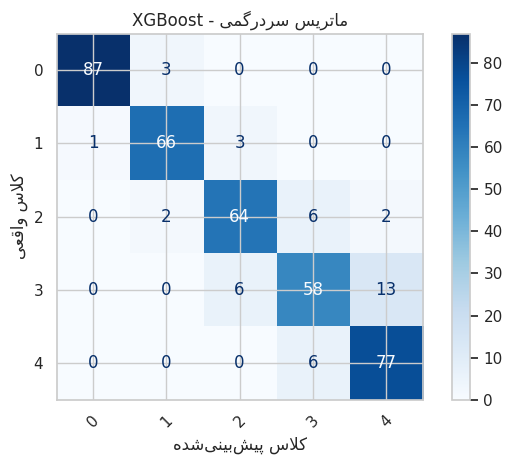

📈 ROC AUC (micro): 0.933
📈 ROC AUC (macro): 0.932


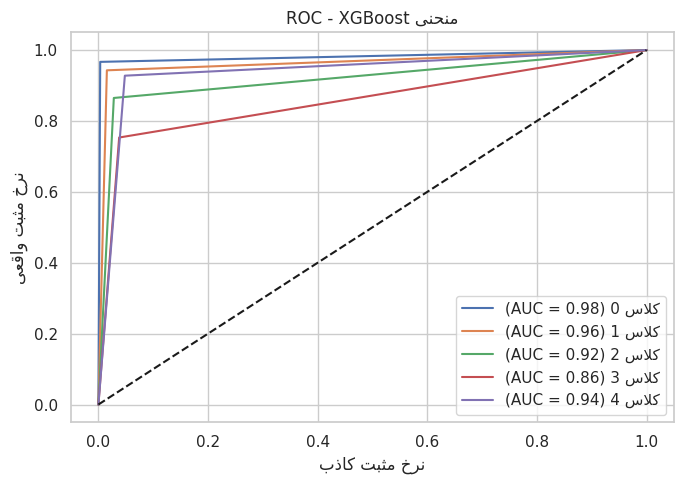


🔷 مدل: Random Forest
✅ دقت (Accuracy): 0.845
              precision    recall  f1-score   support

           0      0.966     0.956     0.961        90
           1      0.889     0.914     0.901        70
           2      0.866     0.784     0.823        74
           3      0.705     0.714     0.710        77
           4      0.795     0.843     0.819        83

    accuracy                          0.845       394
   macro avg      0.844     0.842     0.843       394
weighted avg      0.847     0.845     0.845       394

🤝 ضریب کاپا (Kappa): 0.806
📉 RMSE: 0.412


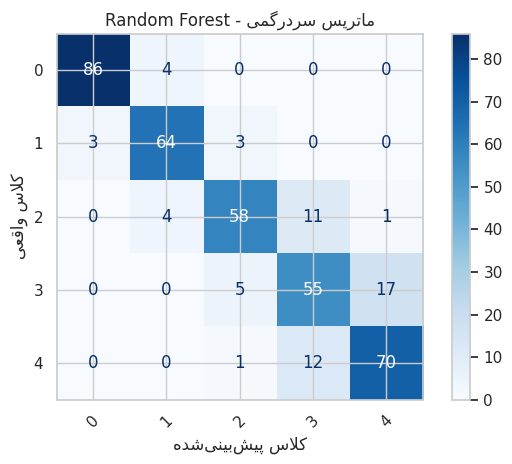

📈 ROC AUC (micro): 0.903
📈 ROC AUC (macro): 0.902


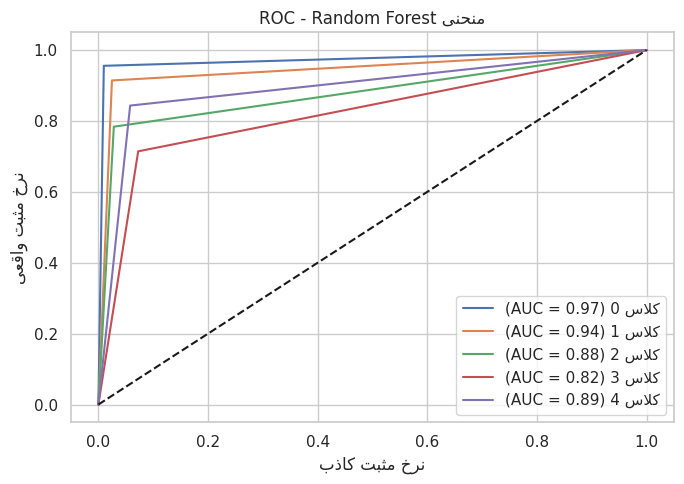


🔷 مدل: SVM
✅ دقت (Accuracy): 0.728
              precision    recall  f1-score   support

           0      0.808     0.889     0.847        90
           1      0.716     0.686     0.701        70
           2      0.891     0.662     0.760        74
           3      0.567     0.714     0.632        77
           4      0.724     0.663     0.692        83

    accuracy                          0.728       394
   macro avg      0.741     0.723     0.726       394
weighted avg      0.742     0.728     0.730       394

🤝 ضریب کاپا (Kappa): 0.659
📉 RMSE: 0.585


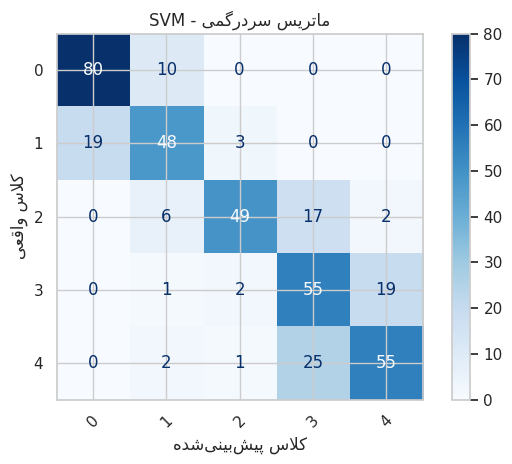

📈 ROC AUC (micro): 0.830
📈 ROC AUC (macro): 0.827


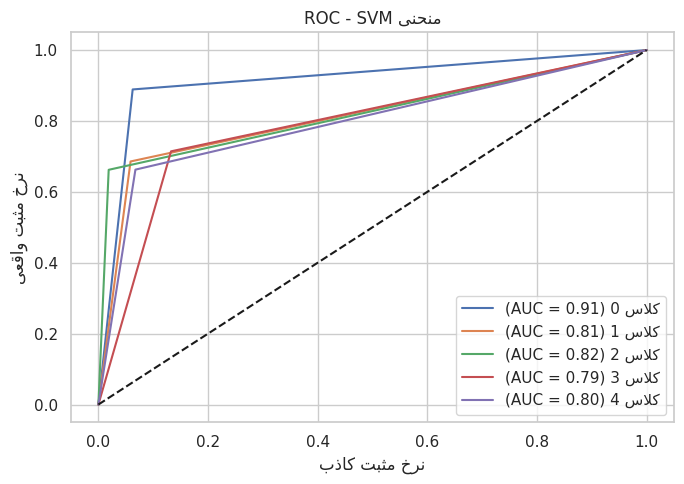

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, cohen_kappa_score, mean_squared_error,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

# ✅ پشتیبانی از متن فارسی
import arabic_reshaper
from bidi.algorithm import get_display

def fix_farsi(text):
    return get_display(arabic_reshaper.reshape(text))

# مرحله 1: فیچرها و هدف
# مرحله 1: فیچرها و هدف (با نام‌های جدید)
features = [
    "Elevation", "Slope", "Distance_to_River", "Lithology", "Land_Cover",
    "Soil_type", "Drainage_Density", "NDVI", "Rainfall", "TWI",
    "SLF", "TPI", "Plan_Curvature", "Profile_Curvature", "Aspect"
]

X = df_clean[features]
y = df_clean["Hazard_Level_Label"]


# مرحله 2: نرمال‌سازی
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# مرحله 3: تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# مرحله 4: تعریف مدل‌ها
models = {
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8,
        colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss', random_state=42
    ),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', probability=True),
}

# مرحله 5: آموزش و ارزیابی مدل‌ها
classes = sorted(y.unique())

for name, model in models.items():
    print(f"\n🔷 مدل: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # دقت
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ دقت (Accuracy): {acc:.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # ضریب کاپا
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"🤝 ضریب کاپا (Kappa): {kappa:.3f}")

    # RMSE
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    print(f"📉 RMSE: {rmse:.3f}")

    # ماتریس سردرگمی
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(fix_farsi(f"ماتریس سردرگمی - {name}"))
    plt.xlabel(fix_farsi("کلاس پیش‌بینی‌شده"))
    plt.ylabel(fix_farsi("کلاس واقعی"))
    plt.tight_layout()
    plt.show()

    # ROC و AUC (با باینری‌سازی)
    y_test_bin = label_binarize(y_test, classes=classes)
    y_pred_bin = label_binarize(y_pred, classes=classes)

    try:
        auc_micro = roc_auc_score(y_test_bin, y_pred_bin, average="micro")
        auc_macro = roc_auc_score(y_test_bin, y_pred_bin, average="macro")
        print(f"📈 ROC AUC (micro): {auc_micro:.3f}")
        print(f"📈 ROC AUC (macro): {auc_macro:.3f}")
    except ValueError as e:
        print(f"⚠️ ROC AUC محاسبه نشد: {e}")
        continue

    # رسم ROC Curve
    plt.figure(figsize=(7, 5))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_pred_bin[:, i])
        plt.plot(fpr, tpr, label=fix_farsi(f'کلاس {cls} (AUC = {auc:.2f})'))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel(fix_farsi("نرخ مثبت کاذب"))
    plt.ylabel(fix_farsi("نرخ مثبت واقعی"))
    plt.title(fix_farsi(f"منحنی ROC - {name}"))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [37]:
# ذخیره دیتافریم نهایی شامل Hazard_Score و Hazard_Level_Label
df_clean.to_csv("final_data.csv", index=False)
print("✅ فایل final_data.csv ذخیره شد.")
df_clean.head()

✅ فایل final_data.csv ذخیره شد.


Aspect      NDVI       SLF  Land_Cover  Distance_to_River  \
0  180.00000  0.010117  0.000000          11           676.8309   
1  260.53770 -0.036375  1.605460          11           523.9275   
2  225.00000  0.040386  0.000000          11          1369.5255   
3  135.00000  0.040737  0.081220          11          1664.1213   
4  348.69006  0.026272  0.225956          11          1127.6968   

   Plan_Curvature     Slope  Drainage_Density  Profile_Curvature  \
0       -0.000000  0.954841          0.038566          -0.111111   
1       -0.000000  2.901822          0.040074           0.111111   
2        0.138889  1.012750          0.042231          -0.083333   
3       -0.083333  0.337615          0.041855           0.138889   
4       -0.000000  1.217118          0.042105          -0.111111   

            SPI  ...        TWI              x             y  Soil_type  \
0 -3.402823e+38  ...   7.495542  275413.441975  3.325867e+06          5   
1  3.144780e+00  ...   8.580455  274595.877840  3.326176e+06          5   
2 -3.402823e+38  ...   7.436651  272852.003358  3.326053e+06          5   
3  5.235880e-01  ...  10.327023  272732.940619  3.325780e+06          5   
4  1.964859e-01  ...   7.945935  273145.691445  3.326161e+06          5   

   Elevation  Lithology  Prediction  Hazard_Score  Hazard_Level  \
0        3.0         35           1      0.635064        Normal   
1        1.0         35           1      0.604768        Normal   
2        3.0         35           1      0.629536        Normal   
3        0.0         35           1      0.668915        Normal   
4        2.0         35           1      0.614165        Normal   

   Hazard_Level_Label  
0                   2  
1                   2  
2                   2  
3                   2  
4                   2  

[5 rows x 25 columns]

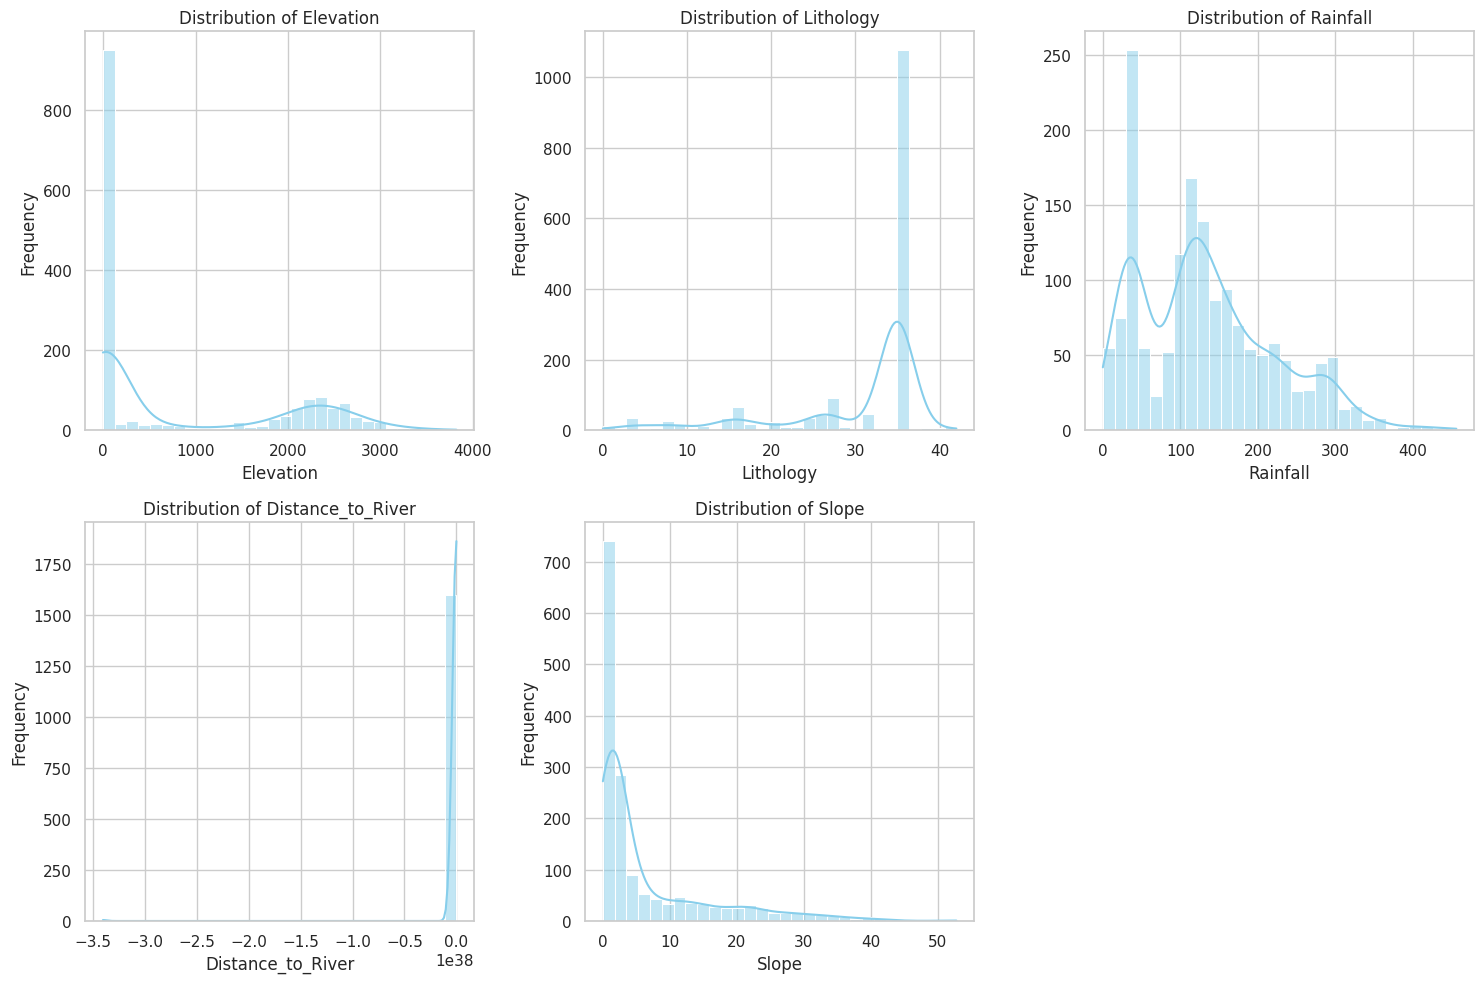

In [38]:

# انتخاب چند ویژگی مهم برای نمایش توزیع آن‌ها
selected_features = ['Elevation', 'Lithology', 'Rainfall', 'Distance_to_River', 'Slope']

# رسم هیستوگرام (توزیع) برای هر ویژگی
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

#  نمودار توزیع پنج ویژگی کلیدی در پروژه مدل‌سازی خطر سیلاب را نمایش می‌دهد:



In [39]:
# رسم BoxPlot برای بررسی توزیع و داده‌های پرت ویژگی‌ها
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, y=feature, color='lightgreen')
    plt.title(f'BoxPlot of {feature}')
    plt.ylabel(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# نمودارهای زیر BoxPlot برای پنج ویژگی کلیدی پروژه را نشان می‌دهند. این نمودارها اطلاعات زیر را به ما می‌دهند:



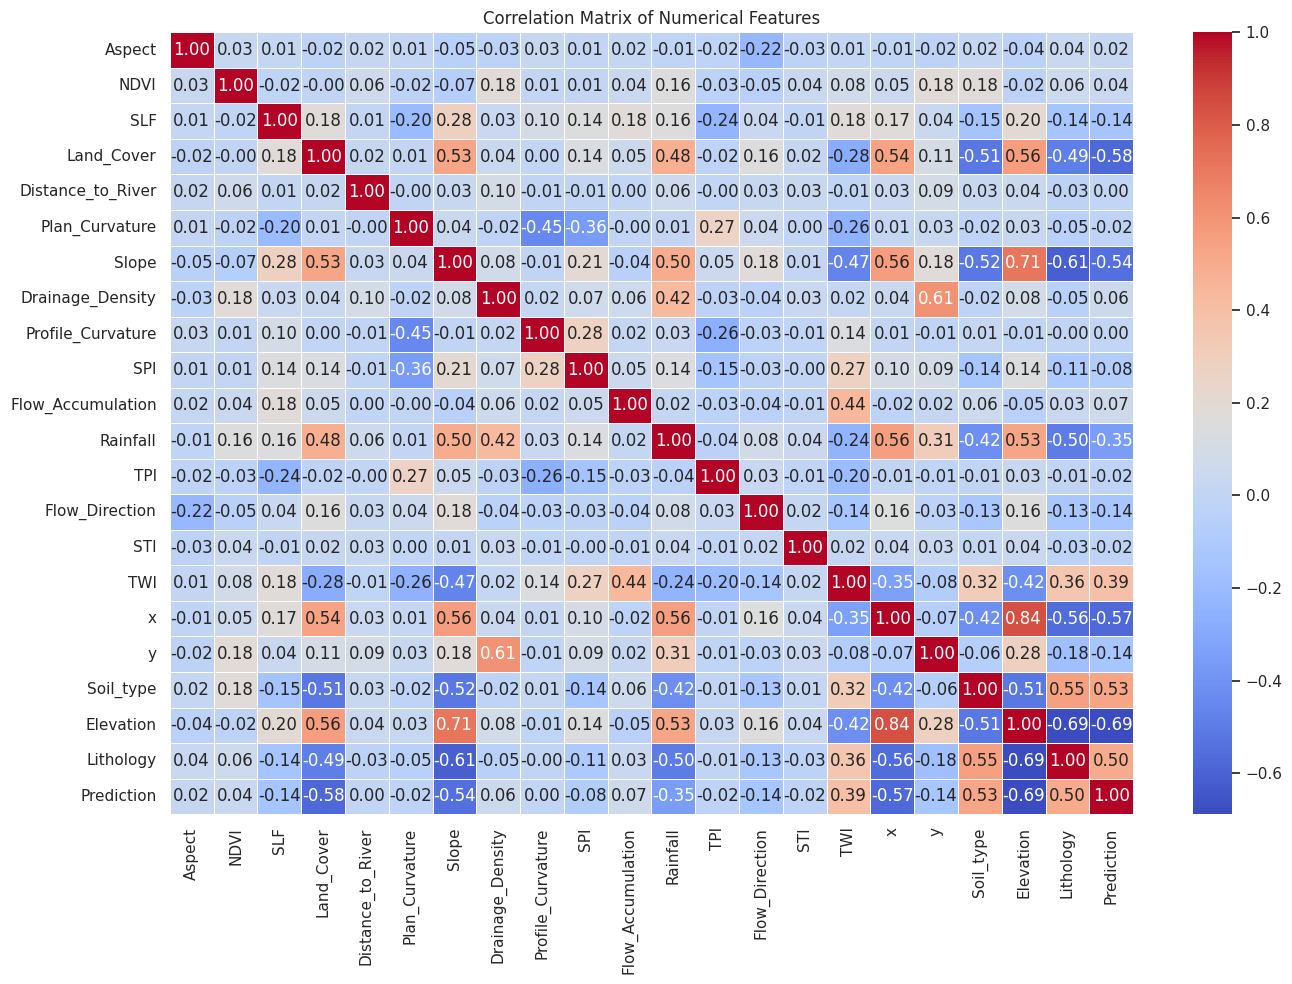

In [40]:
# رسم ماتریس همبستگی بین ویژگی‌ها

# انتخاب فقط ویژگی‌های عددی (به جز Flood که می‌تونه در آخر بررسی بشه)
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# محاسبه ماتریس همبستگی
correlation_matrix = numeric_features.corr()

# رسم heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


# نمودار  Correlation Matrix (ماتریس همبستگی) بین ویژگی‌های عددی پروژه را نمایش می‌دهد.


# ---

#  این نمودار چه کمکی می‌کند؟

# همبستگی بالا (مقادیر نزدیک به 1 یا -1): نشان می‌دهد که دو ویژگی احتمالاً اطلاعات تکراری دارند.

# همبستگی پایین (نزدیک 0): دو ویژگی مستقل از یکدیگرند.



# ---

#  نکات مهم از این ماتریس:

# ویژگی‌هایی مثل Slopee و StreamPowerIndex یا TopographicWetnessIndex با برخی ویژگی‌های دیگر همبستگی نسبتاً بالا دارند.

# همبستگی شدید بین SlopeLengthFactor و Slopee ممکن است منجر به multicollinearity شود (در بعضی مدل‌ها مثل Logistic Regression مشکل‌ساز است).

# NDVI2, Rainfall و Elevation تقریباً مستقل‌ترند و اطلاعات غیرتکراری به مدل اضافه می‌کنند.

/tmp/ipython-input-41-2396361293.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Prediction", y="Rainfall", data=df, ci=None, palette="coolwarm")
/tmp/ipython-input-41-2396361293.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Prediction", y="Rainfall", data=df, ci=None, palette="coolwarm")


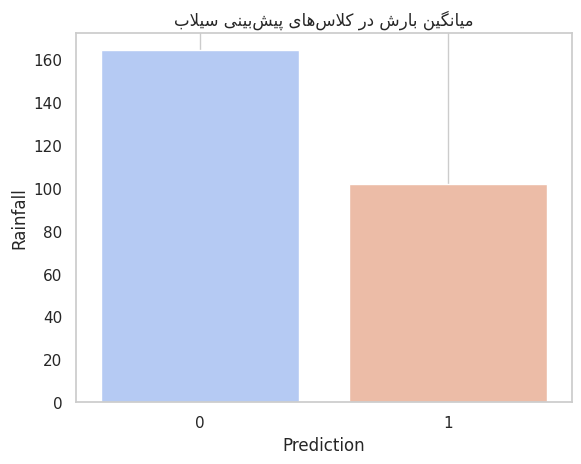

/tmp/ipython-input-41-2396361293.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Prediction", y="Distance_to_River", data=df, palette="pastel")


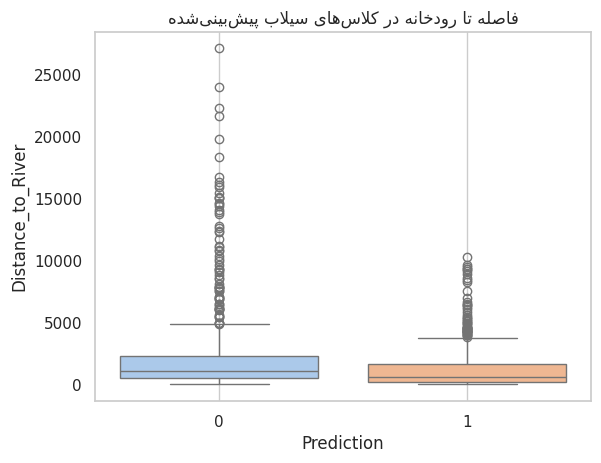

/tmp/ipython-input-41-2396361293.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Prediction", y="NDVI", data=df, palette="Set2")


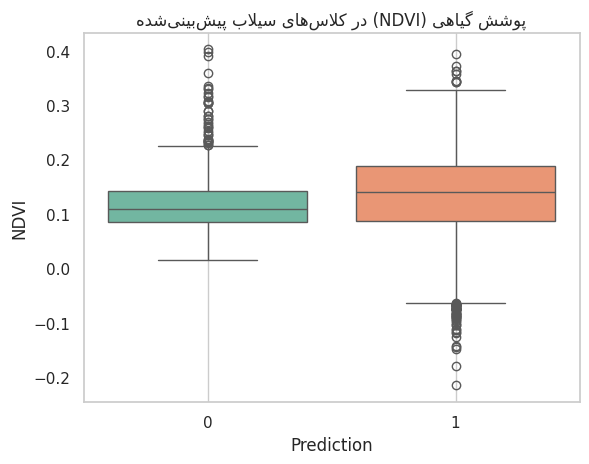

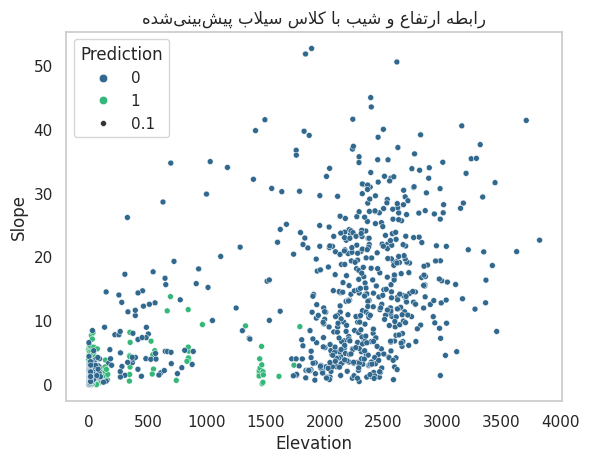

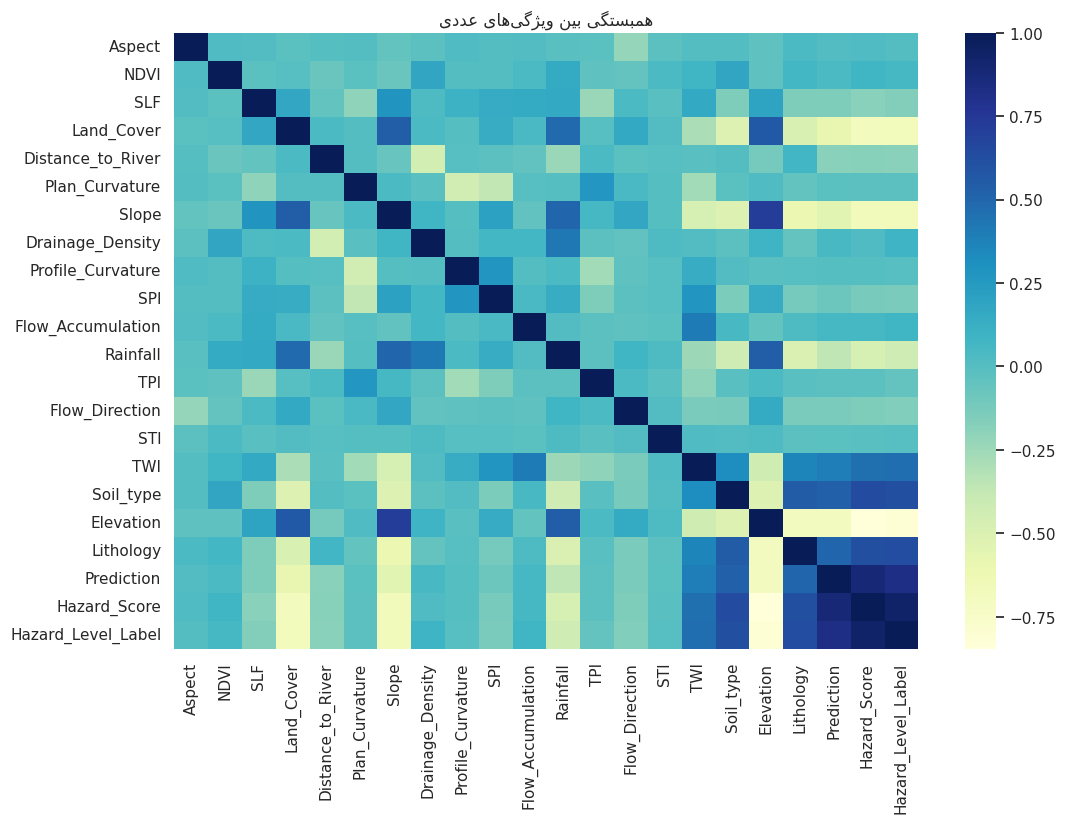

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# تابع اصلاح متن فارسی
def fa(text):
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)

# خواندن فایل دیتا
df = pd.read_csv("final_data.csv")
df = df.drop(columns=["x", "y"])

# اطمینان از اینکه Prediction عددیه
df["Prediction"] = df["Prediction"].astype(int)

# 1. Barplot از Rainfall به تفکیک Prediction
plt.figure()
sns.barplot(x="Prediction", y="Rainfall", data=df, ci=None, palette="coolwarm")
plt.title(fa("میانگین بارش در کلاس‌های پیش‌بینی سیلاب"))
plt.grid()
plt.show()

# 2. Boxplot از Distance_to_River بر اساس Prediction
plt.figure()
sns.boxplot(x="Prediction", y="Distance_to_River", data=df, palette="pastel")
plt.title(fa("فاصله تا رودخانه در کلاس‌های سیلاب پیش‌بینی‌شده"))
plt.grid()
plt.show()

# 3. Boxplot از NDVI بر اساس Prediction
plt.figure()
sns.boxplot(x="Prediction", y="NDVI", data=df, palette="Set2")
plt.title(fa("پوشش گیاهی (NDVI) در کلاس‌های سیلاب پیش‌بینی‌شده"))
plt.grid()
plt.show()

# 4. Scatter Elevation و Slope با رنگ Prediction
plt.figure()
sns.scatterplot(data=df, x="Elevation", y="Slope", hue="Prediction", palette="viridis", size=0.1)
plt.title(fa("رابطه ارتفاع و شیب با کلاس سیلاب پیش‌بینی‌شده"))
plt.grid()
plt.show()

# 5. Heatmap همبستگی بین ویژگی‌های عددی
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu")
plt.title(fa("همبستگی بین ویژگی‌های عددی"))
plt.show()


/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


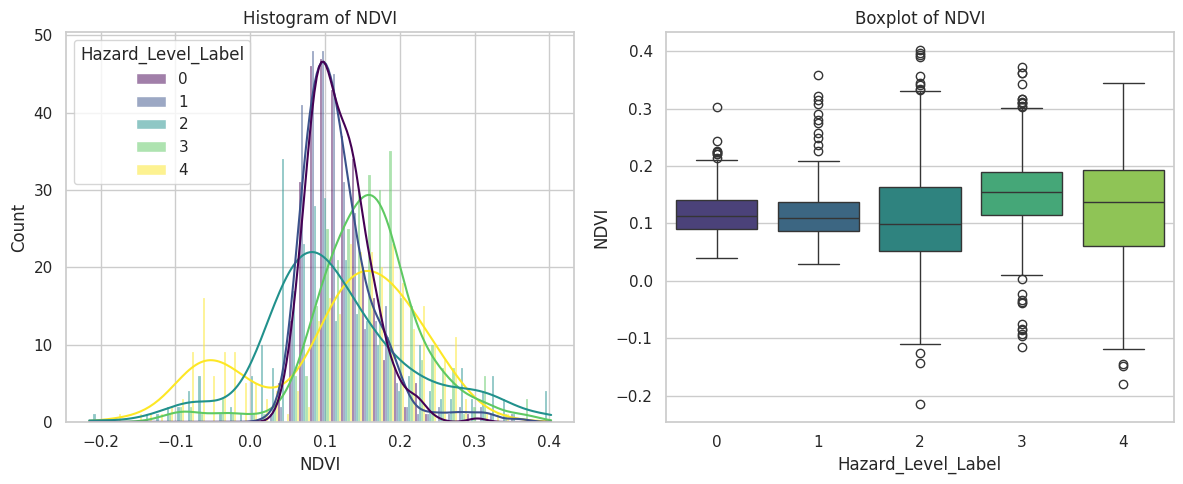

/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


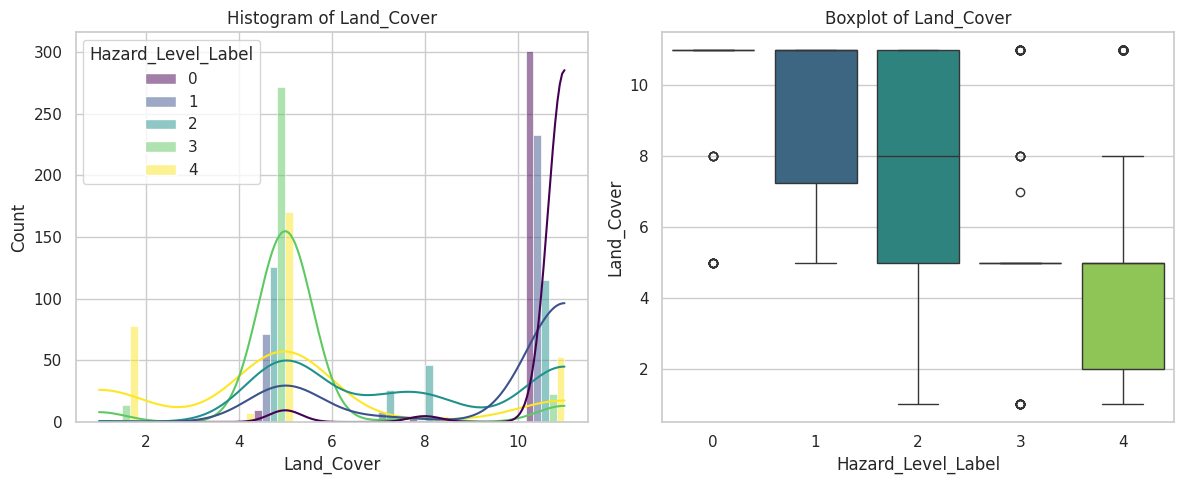

/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


✅ Finished group 1 of 4.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


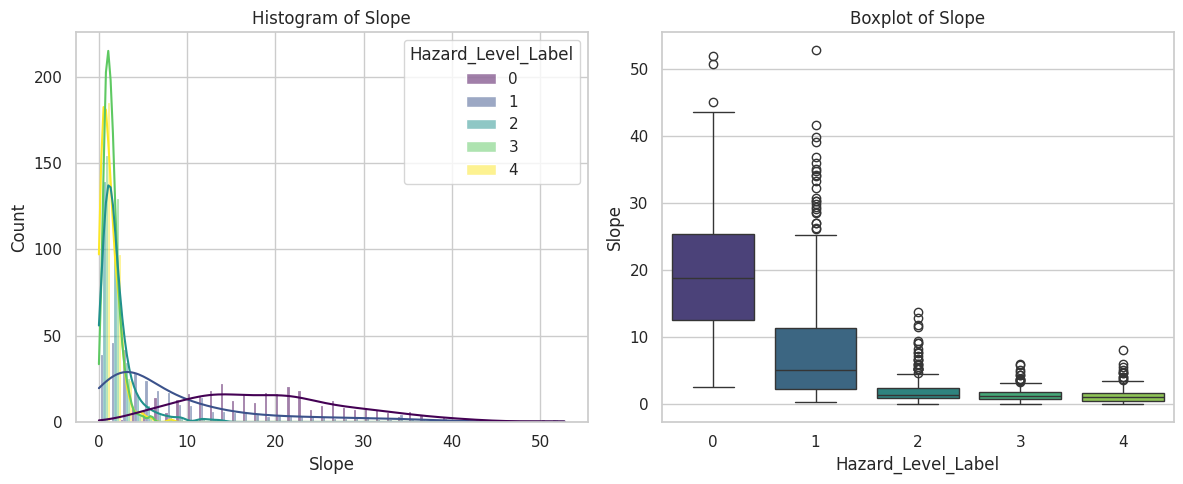

/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


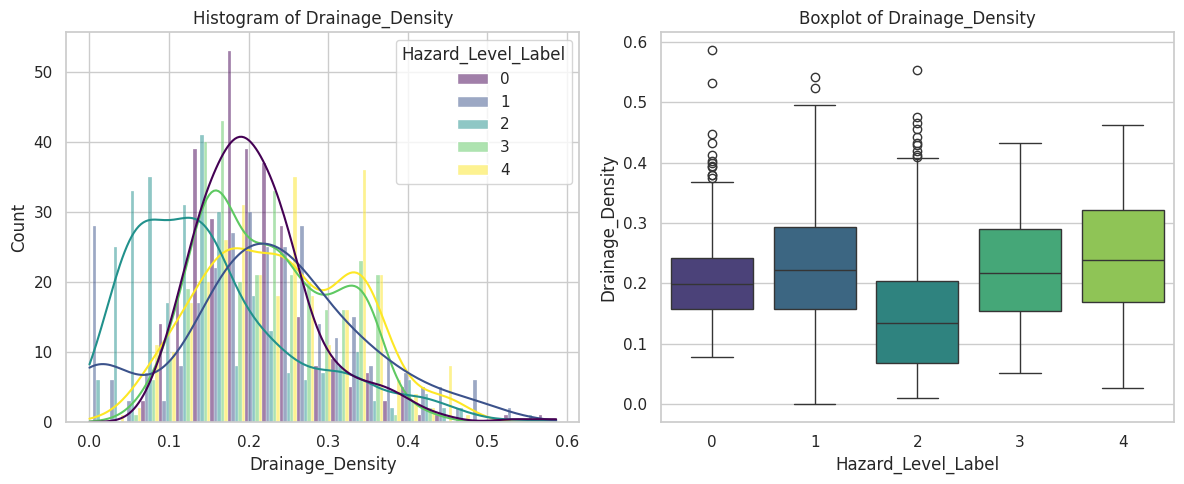

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


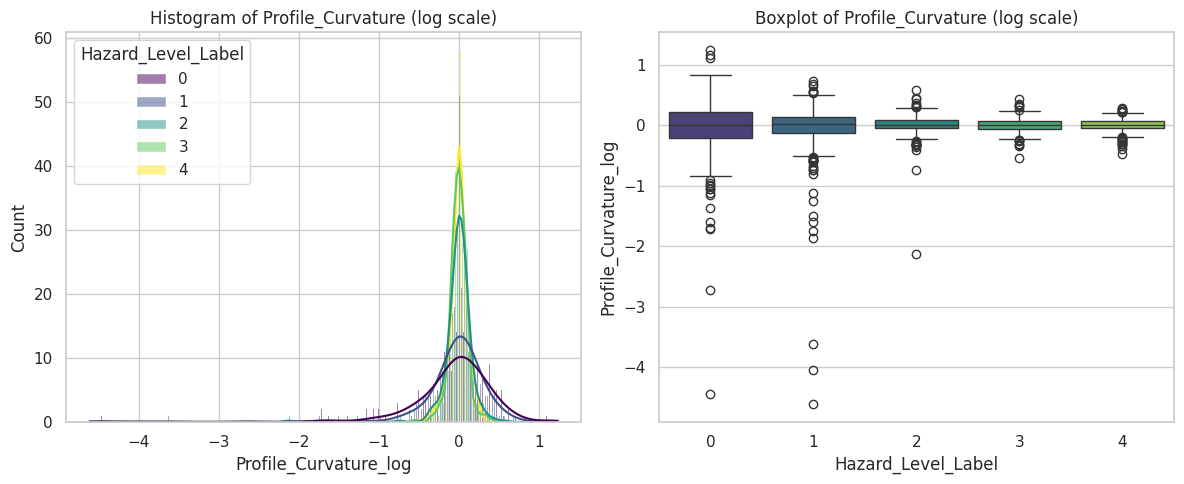

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


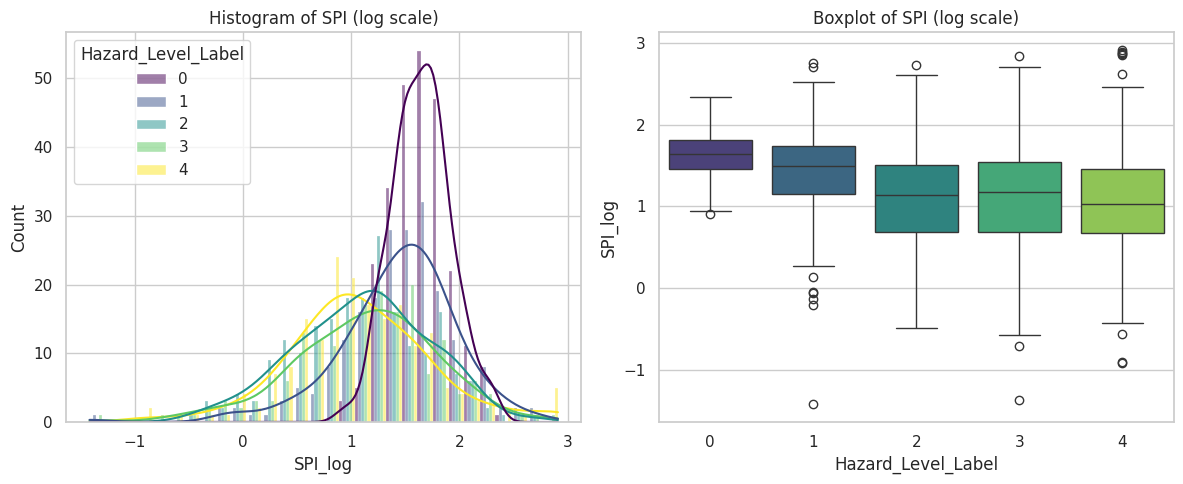

✅ Finished group 2 of 4.


/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


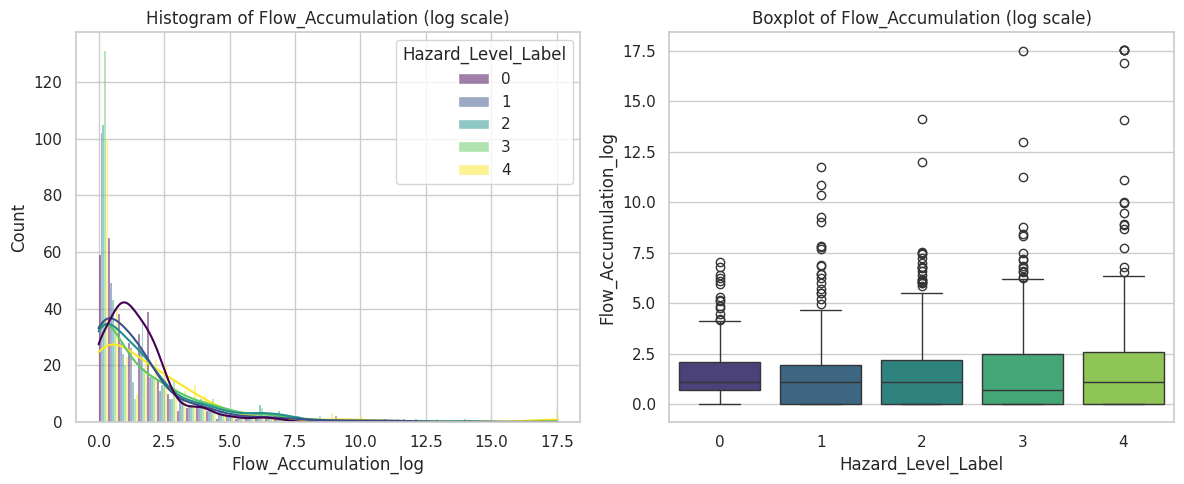

/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


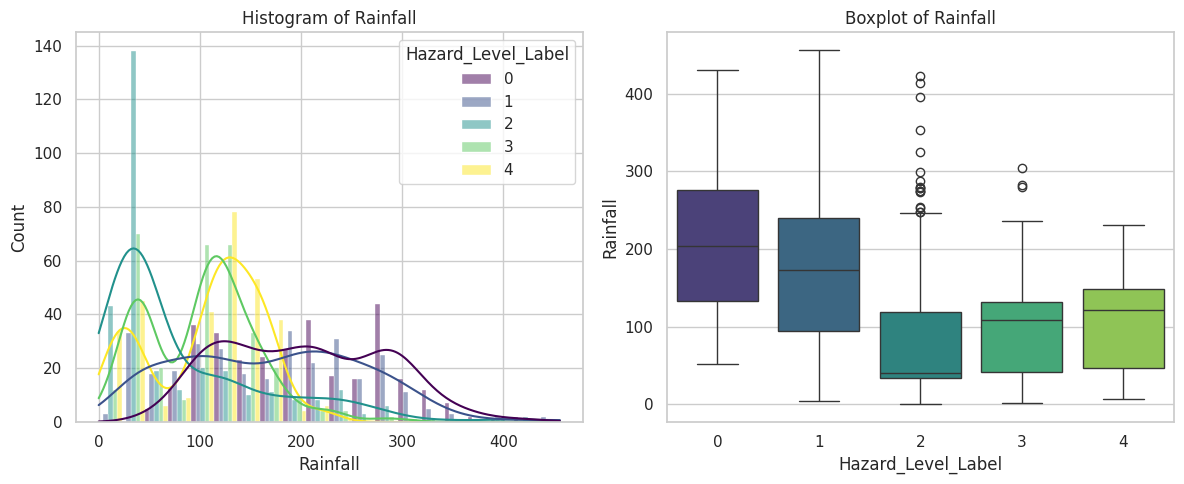

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


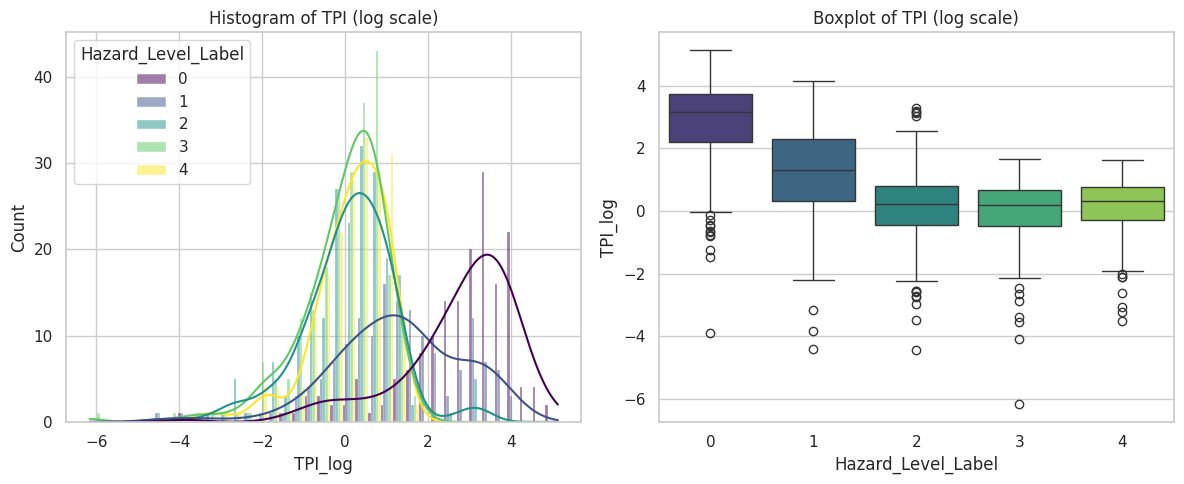

/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


✅ Finished group 3 of 4.


/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


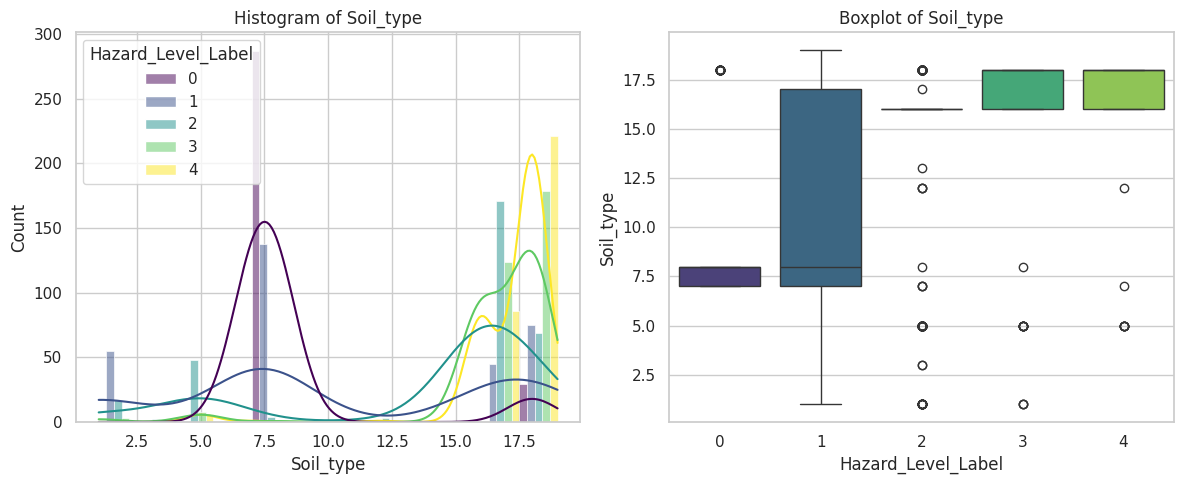

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


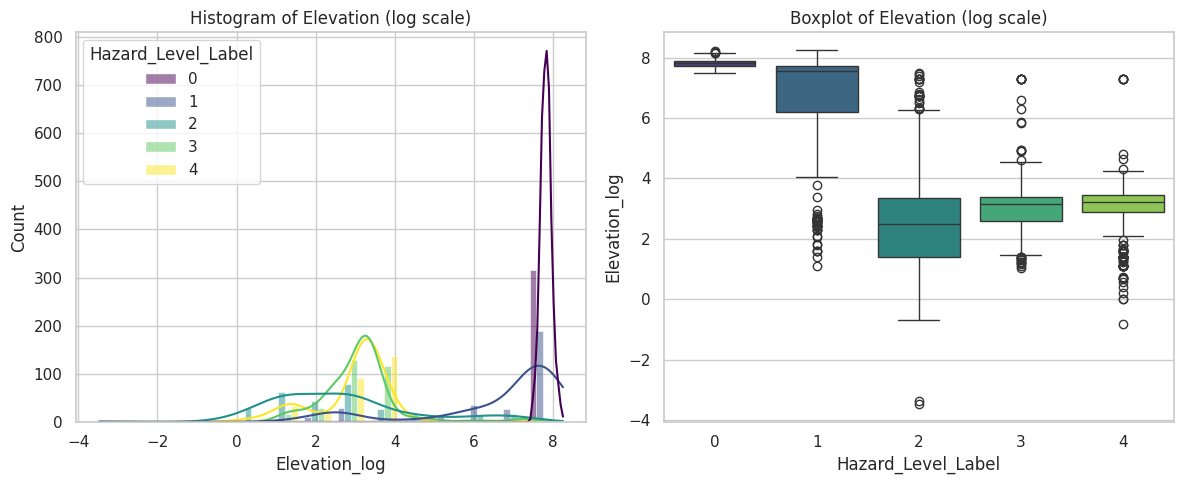

/tmp/ipython-input-27-2477618957.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')


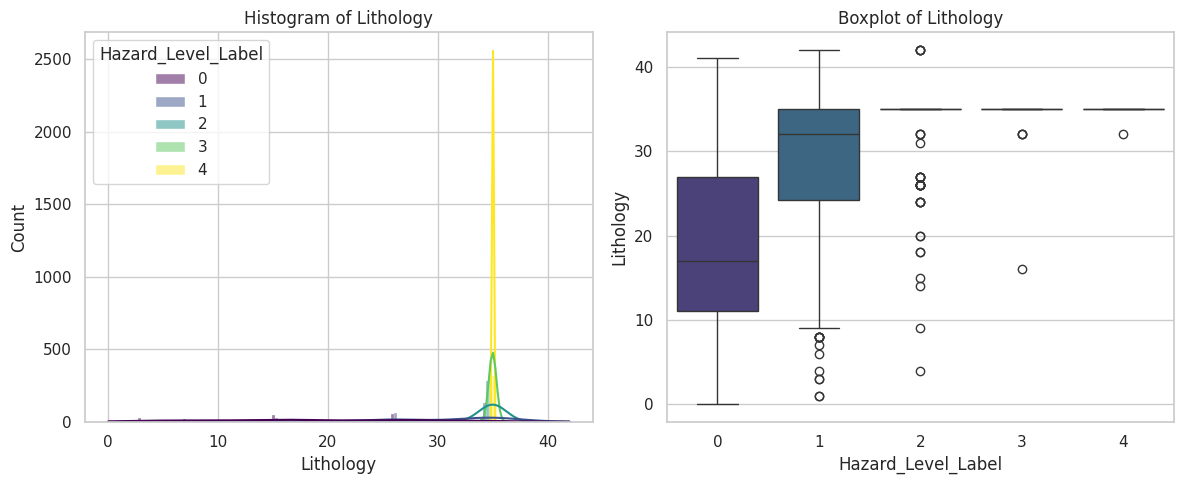

✅ Finished group 4 of 4.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# خواندن فایل
df = pd.read_csv("final_data.csv")

# حذف x و y
df = df.drop(columns=['x', 'y'])

# تنظیمات گرافیکی
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'

# تعریف تابع تشخیص کشیدگی داده (outlier-heavy)
def needs_log_transform(series):
    q75 = series.quantile(0.75)
    q50 = series.quantile(0.50)
    q25 = series.quantile(0.25)
    iqr = q75 - q25
    return q75 > 100 * q25 or series.max() > 1000 * q50

# انتخاب فیچرها با نام‌های جدید
exclude_cols = ['Hazard_Level_Label', 'Hazard_Level', 'Prediction', 'Hazard_Score']
features = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['float64', 'int64']]

# گروه‌بندی 5تایی
chunk_size = 5
num_chunks = math.ceil(len(features) / chunk_size)

for i in range(num_chunks):
    chunk = features[i * chunk_size:(i + 1) * chunk_size]

    for feature in chunk:
        data = df.copy()

        # اعمال log1p فقط در صورت نیاز
        if needs_log_transform(data[feature]):
            data[f'{feature}_log'] = np.log1p(data[feature])
            plot_feature = f'{feature}_log'
            title_suffix = " (log scale)"
        else:
            plot_feature = feature
            title_suffix = ""

        # رسم نمودار
        plt.figure(figsize=(12, 5))

        # هیستوگرام
        plt.subplot(1, 2, 1)
        sns.histplot(data=data, x=plot_feature, hue='Hazard_Level_Label', kde=True, palette='viridis', multiple="dodge")
        plt.title(f'Histogram of {feature}{title_suffix}')

        # باکس‌پلات
        plt.subplot(1, 2, 2)
        sns.boxplot(data=data, x='Hazard_Level_Label', y=plot_feature, palette='viridis')
        plt.title(f'Boxplot of {feature}{title_suffix}')

        plt.tight_layout()
        plt.show()

    print(f"✅ Finished group {i + 1} of {num_chunks}.")


/tmp/ipython-input-42-3736154754.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask_poly = basin.unary_union


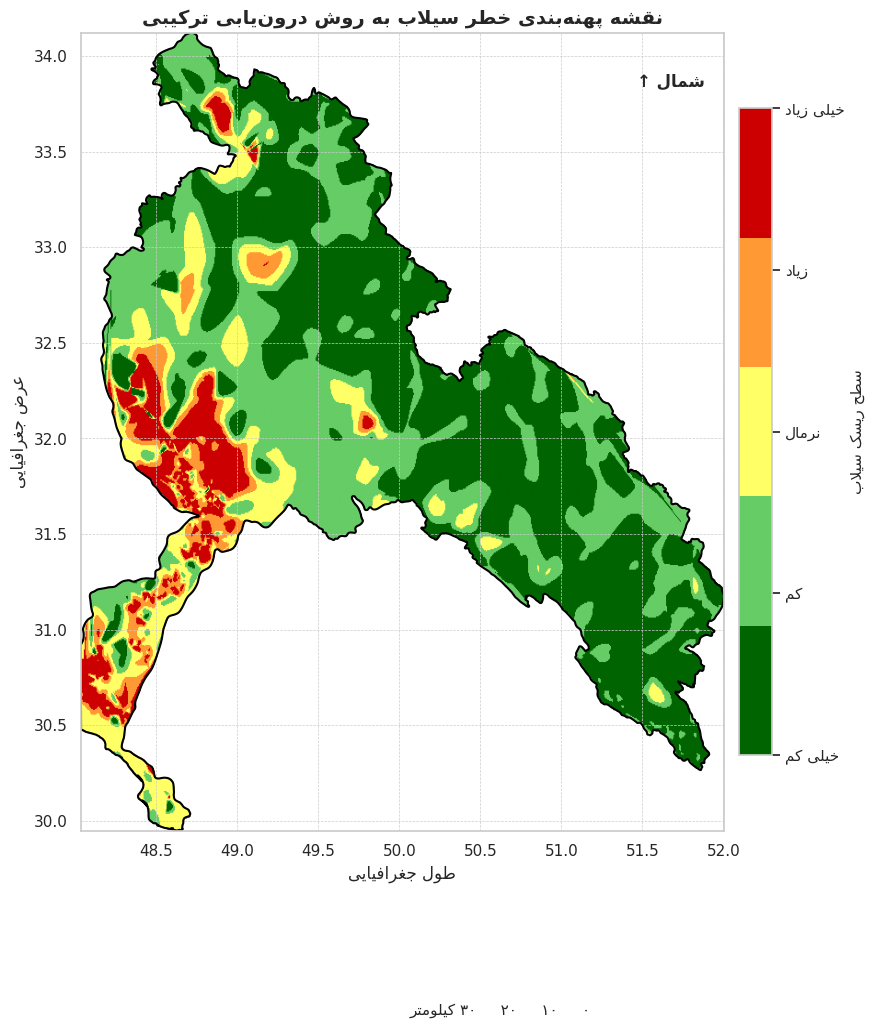

✅ نقشه نهایی ساخته شد و ذخیره شد: final_flood_map_professional_style.png


In [42]:
# 📦 وارد کردن کتابخانه‌ها
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
import arabic_reshaper
from bidi.algorithm import get_display

# 📝 تابع فارسی‌ساز برای نوشتار راست‌چین
def farsi(text):
    return get_display(arabic_reshaper.reshape(text))

# 🎯 مرحله ۱: خواندن فایل ریسک
df = pd.read_csv('final_data.csv')
df['Hazard_Level'] = df['Hazard_Level'].str.strip().str.title()
Hazard_map = {
    'Very Low': 1,
    'Low': 2,
    'Normal': 3,
    'High': 4,
    'Very High': 5
}
df['Hazard_Level_Code'] = df['Hazard_Level'].map(Hazard_map)
df = df[~df['Hazard_Level_Code'].isna()]

# 🎯 مرحله ۲: ساخت GeoDataFrame
geometry = [Point(xy) for xy in zip(df['x'], df['y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:32639').to_crs(epsg=4326)

# 🎯 مرحله ۳: خواندن shapefile مرز حوضه
basin = gpd.read_file('BASIN.shp').to_crs(epsg=4326)
basin_bounds = basin.total_bounds  # [minx, miny, maxx, maxy]

# 🎯 مرحله ۴: ساخت گرید در محدوده حوضه
grid_x, grid_y = np.mgrid[
    basin_bounds[0]:basin_bounds[2]:700j,
    basin_bounds[1]:basin_bounds[3]:700j
]

# 🎯 مرحله ۵: درون‌یابی ترکیبی (linear + nearest برای جلوگیری از NaN)
# ابتدا linear
grid_linear = griddata(
    (gdf.geometry.x, gdf.geometry.y),
    gdf['Hazard_Level_Code'],
    (grid_x, grid_y),
    method='cubic'
)

# سپس nearest
grid_nearest = griddata(
    (gdf.geometry.x, gdf.geometry.y),
    gdf['Hazard_Level_Code'],
    (grid_x, grid_y),
    method='nearest'
)

# ترکیب نهایی
grid_z = np.where(np.isnan(grid_linear), grid_nearest, grid_linear)

# 🎯 مرحله ۶: ماسک کردن بیرون از مرز حوضه
from shapely.geometry import Point as ShapelyPoint
grid_points = np.dstack((grid_x, grid_y)).reshape(-1, 2)
mask_poly = basin.unary_union
mask = np.array([mask_poly.contains(ShapelyPoint(xy)) for xy in grid_points])
mask = mask.reshape(grid_z.shape)
grid_z[~mask] = np.nan

# 🎯 مرحله ۷: ترسیم نقشه نهایی
fig, ax = plt.subplots(figsize=(10, 12))

# 🎨 رنگ‌بندی طبقه‌ای مثل مقاله
cmap = ListedColormap(['#006400', '#66cc66', '#ffff66', '#ff9933', '#cc0000'])

# پس‌زمینه رنگی پیوسته
im = ax.imshow(
    grid_z.T,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    origin='lower',
    cmap=cmap,
    vmin=1, vmax=5,
    zorder=0
)

# مرز حوضه
basin.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, zorder=1)

# نقاط مشاهداتی (اختیاری: غیرفعال‌شده)
# gdf.plot(ax=ax, color='blue', markersize=5, marker='*', label=farsi('نقاط مشاهداتی'), zorder=2)

# برچسب محورها
ax.set_xlabel(farsi('طول جغرافیایی'), fontsize=12)
ax.set_ylabel(farsi('عرض جغرافیایی'), fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5)

# فلش شمال
ax.annotate(farsi('شمال ↑'), xy=(0.97, 0.95), xycoords='axes fraction',
            ha='right', va='top', fontsize=12, fontweight='bold')

# نوار مقیاس ساده
ax.annotate(farsi('۰     ۱۰     ۲۰     ۳۰ کیلومتر'), xy=(0.5, 0.01),
            xycoords='figure fraction', ha='center', fontsize=11)

# نوار راهنمای رنگ
cbar = plt.colorbar(im, ax=ax, shrink=0.7, pad=0.02, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels([
    farsi('خیلی کم'), farsi('کم'), farsi('نرمال'), farsi('زیاد'), farsi('خیلی زیاد')
])
cbar.set_label(farsi('سطح ریسک سیلاب'), fontsize=11)

# عنوان
ax.set_title(farsi('نقشه پهنه‌بندی خطر سیلاب به روش درون‌یابی ترکیبی'), fontsize=14, fontweight='bold')

# ذخیره خروجی
plt.savefig('final_flood_map_professional_style.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ نقشه نهایی ساخته شد و ذخیره شد: final_flood_map_professional_style.png")


/tmp/ipython-input-43-1459917574.py:37: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  within_mask = grid_gdf.within(basin.unary_union)


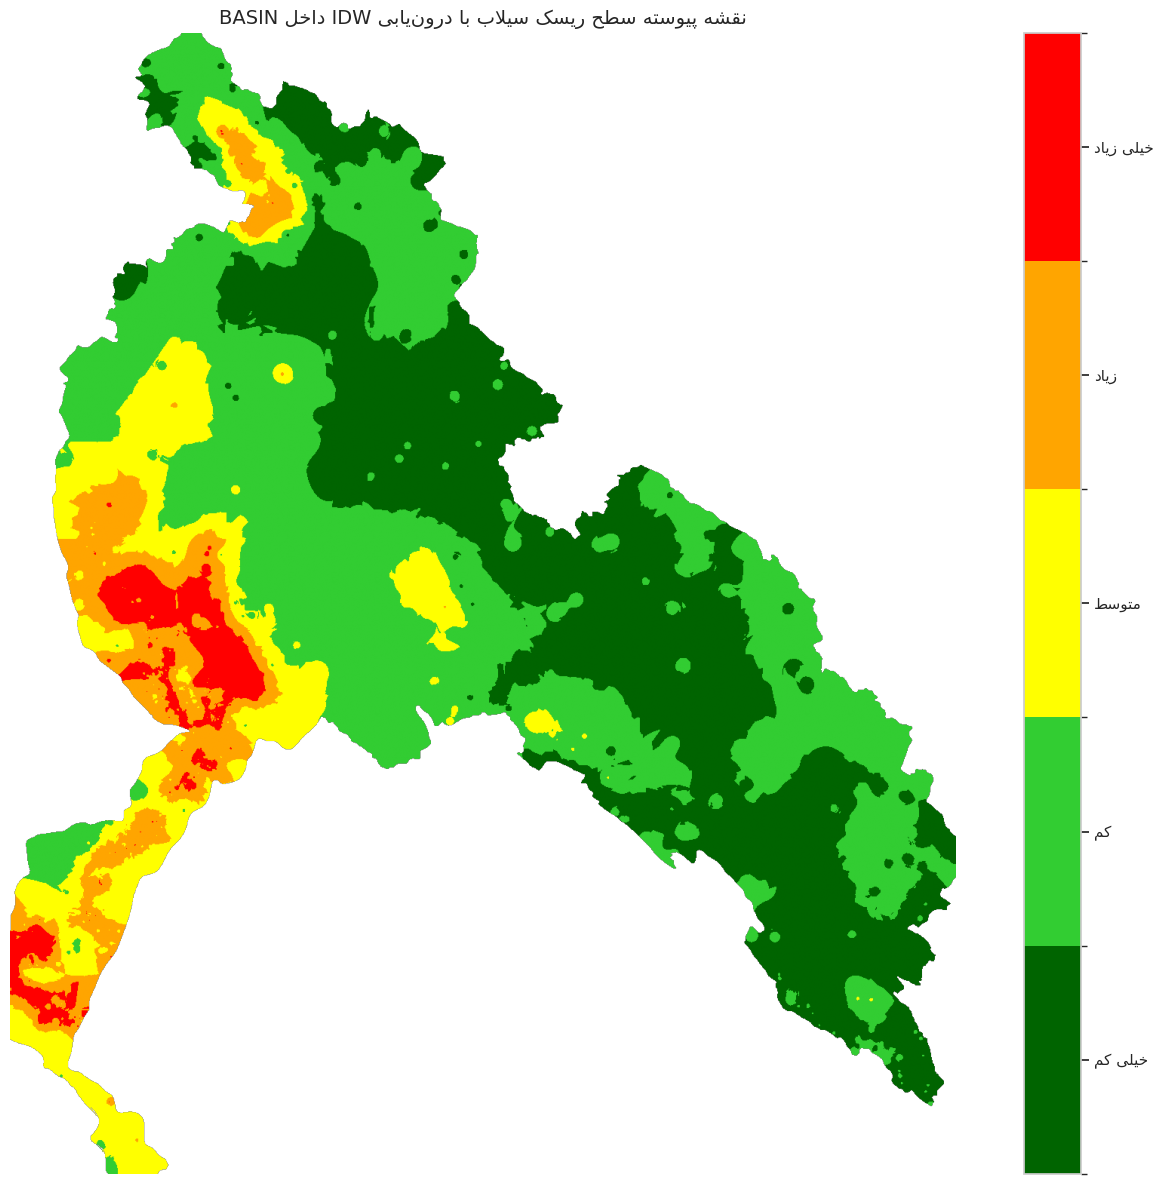

In [43]:
!pip install geopandas shapely rasterio --quiet

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import arabic_reshaper
from bidi.algorithm import get_display
from shapely.geometry import Point
from scipy.spatial import cKDTree
import rasterio
from rasterio.transform import from_origin

# تابع اصلاح متن فارسی
def fa(text):
    return get_display(arabic_reshaper.reshape(text))

# 1. خواندن داده
df = pd.read_csv("final_data.csv")
df = df[df["Hazard_Level_Label"].isin([0, 1, 2, 3, 4])]

# 2. خواندن مرز BASIN
basin = gpd.read_file("BASIN.shp")

# 3. ساخت گرید روی محدوده Basin
pixel_size = 300
xmin, xmax = df["x"].min(), df["x"].max()
ymin, ymax = df["y"].min(), df["y"].max()
x_coords = np.arange(xmin, xmax, pixel_size)
y_coords = np.arange(ymin, ymax, pixel_size)
xx, yy = np.meshgrid(x_coords, y_coords)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# 4. حذف پیکسل‌هایی که خارج از BASIN هستن
grid_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in grid_points], crs=basin.crs)
within_mask = grid_gdf.within(basin.unary_union)
valid_points = grid_points[within_mask]

# 5. ساخت KDTree
data_points = df[["x", "y"]].values
data_values = df["Hazard_Level_Label"].values
tree = cKDTree(data_points)

# 6. اجرای IDW
distances, indices = tree.query(valid_points, k=8)
weights = 1 / (distances + 1e-8)
weighted_vals = np.sum(weights * data_values[indices], axis=1) / np.sum(weights, axis=1)

# 7. ساخت رستر نهایی
raster = np.full(xx.shape, np.nan)
for i, (x, y) in enumerate(valid_points):
    col = int((x - xmin) / pixel_size)
    row = int((y - ymin) / pixel_size)
    raster[row, col] = weighted_vals[i]

# 8. تنظیم حاشیه و extent
width = xmax - xmin
height = ymax - ymin
pad_x = width * 0.1
pad_y = height * 0.1
extent = (
    xmin - pad_x,
    xmax + pad_x,
    ymin - pad_y,
    ymax + pad_y
)

# 9. تعریف رنگ‌ها و رسم
cmap = mcolors.ListedColormap(["#006400", "#32CD32", "#FFFF00", "#FFA500", "#FF0000"])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(14, 12))
plt.imshow(raster, cmap=cmap, norm=norm, origin="lower", extent=extent)
cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4])
cbar.ax.set_yticklabels([
    fa("خیلی کم"), fa("کم"), fa("متوسط"), fa("زیاد"), fa("خیلی زیاد")
])
plt.title(fa("نقشه پیوسته سطح ریسک سیلاب با درون‌یابی IDW داخل BASIN"), fontsize=14)
plt.axis("off")
plt.tight_layout()

# 10. ذخیره به PNG
plt.savefig("flood_Hazard_map.png", dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

# ✅ 11. ذخیره درست به GeoTIFF با Mask
transform = from_origin(xmin, ymax, pixel_size, pixel_size)

# تبدیل NaN به مقدار nodata و نوع float32
raster_masked = np.where(np.isnan(raster), -9999, raster).astype("float32")

with rasterio.open(
    "flood_Hazard_map_fixed.tif",
    "w",
    driver="GTiff",
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype="float32",
    crs=basin.crs.to_wkt(),
    transform=transform,
    nodata=-9999  # مقدار nodata به‌درستی تنظیم شده
) as dst:
    dst.write(raster_masked, 1)
    dst.update_tags(**{'TIFFTAG_SOFTWARE': 'Flood Hazard Mapping Script'})


✅ فایل با موفقیت باز شد
📏 اندازه (ارتفاع × عرض): 1514 × 1254
📌 سیستم مختصات (CRS): EPSG:32639
📐 Transform: | 300.00, 0.00, 216351.07|
| 0.00,-300.00, 3775657.77|
| 0.00, 0.00, 1.00|


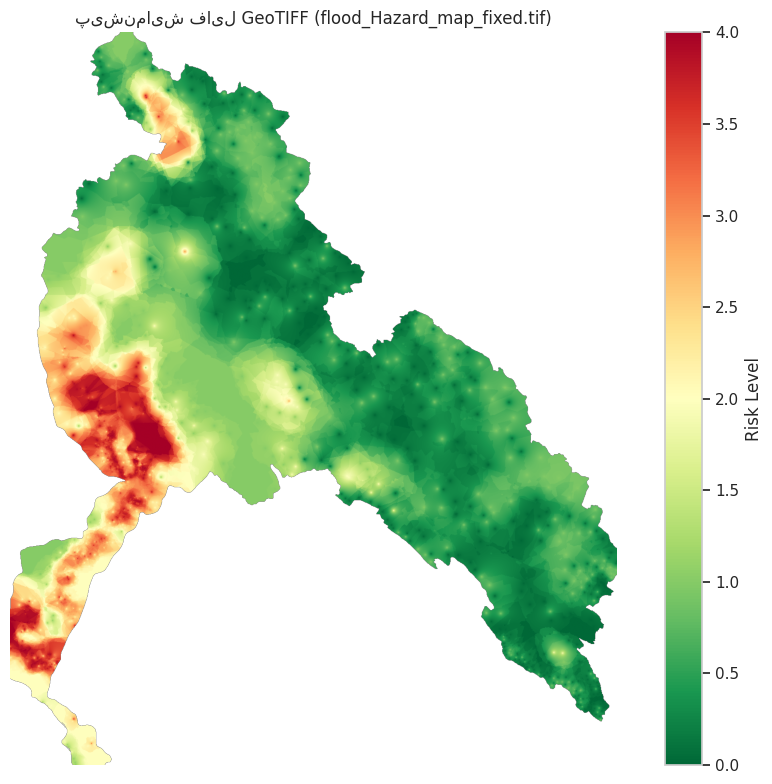

In [44]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# باز کردن فایل GeoTIFF
with rasterio.open("flood_Hazard_map_fixed.tif") as src:
    print("✅ فایل با موفقیت باز شد")
    print("📏 اندازه (ارتفاع × عرض):", src.height, "×", src.width)
    print("📌 سیستم مختصات (CRS):", src.crs)
    print("📐 Transform:", src.transform)

    # خواندن داده رستر
    raster_data = src.read(1)

    # ماسک کردن مقادیر NoData
    raster_data = np.ma.masked_where(raster_data == src.nodata, raster_data)

    # نمایش داده
    plt.figure(figsize=(10, 8))
    cmap = plt.cm.RdYlGn_r  # طیف سبز تا قرمز برعکس مثل نقشه اصلی
    plt.imshow(raster_data, cmap=cmap, origin='lower')
    plt.colorbar(label='Risk Level')
    plt.title("پیش‌نمایش فایل GeoTIFF (flood_Hazard_map_fixed.tif)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
